## Import Excel file in a MongoDB collection
We defined a function to load data from an Excel file to a pandas DataFrame and upload it to a Mongodb collection created on the fly. Here for this demo we use a local installation of MongoDB but ones can use a docker image for MongoDB to avoid installing it on their computer.
For it, simply follow the procedure on README.md and the only modification here is when calling mongoimport function you should specify the db_url as '127.0.0.1' (see commented line)

In [1]:
import pandas as pd
from pymongo import MongoClient
import json

def mongoimport(excel_path, db_name, coll_name, db_url='localhost', db_port=27017):
    """ Imports an excel file to a mongo colection
    """
    client = MongoClient(db_url, db_port)
    db = client[db_name]
    coll = db[coll_name]
    data = pd.read_excel(excel_path)
    payload = json.loads(data.to_json(orient='records',date_format='iso'))
    coll.delete_many({})
    coll.insert_many(payload)

In [2]:
# If using local installation of MongoDB
mongoimport("Online Retail.xlsx", "retail_db", "online_retail")

# If using docker image for MongoDB
#mongoimport("Online Retail.xlsx", "retail_db", "online_retail", db_url='127.0.0.1')

print("The dataset has been successfully imported in MongoDB")

The dataset has been successfully imported in MongoDB


## Start Spark session using MongoDB collection
Start a SparkSession for myApp linked with the local MongoDB (if using docker image, replace localhost by 127.0.0.1). Here we use the previously imported data in the database retail_db and the collection online_retail

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
spark = SparkSession \
.builder \
.appName("myApp") \
.config("spark.mongodb.input.uri", "mongodb://localhost:27017/retail_db.online_retail?readPreference=primaryPreferred") \
.config("spark.mongodb.output.uri", "mongodb://localhost:27017/retail_db.online_retail") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
.getOrCreate()

## Group all transactions by invoice

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# Create the dataframe by loading mongo collection
df = spark.read.format("mongo").load()

# printSchema to get all column names (required only for dev to check spelling)
#df.printSchema()

# Add a new column in Dataframe for the total price of each row (purchase per product per invoice)
df = df.withColumn('TotalPrice', df.Quantity*df.UnitPrice)

# Group all transactions by invoice by summing the total prices and quantities according to InvoiceNo
invoices = df.groupBy("InvoiceNo").sum("TotalPrice","Quantity")
invoices.show()

+---------+------------------+-------------+
|InvoiceNo|   sum(TotalPrice)|sum(Quantity)|
+---------+------------------+-------------+
|   536414|               0.0|           56|
|   536460|295.53999999999996|          158|
|   536398|426.56000000000006|          150|
|   536523|             203.3|          112|
|   536374|             350.4|           32|
|   536386|508.20000000000005|          236|
|   536477|2474.7399999999993|         1070|
|   536528| 313.9299999999999|          124|
|   536366|22.200000000000003|           12|
|   536387|           3193.92|         1440|
|   536385|            130.85|           53|
|   536375|            259.86|           88|
|   536403|192.60000000000002|           97|
|   536367|            278.73|           83|
|   536371|             204.0|           80|
|   536377|22.200000000000003|           12|
|   536389|            358.25|          107|
|   536395| 507.8800000000001|          260|
|   536407|22.200000000000003|           12|
|   536521

## Which product sold the most ?
Here we'll try to group the products, sum their quantities and check which one was the most sold

In [5]:
# Group all transactions by products then order by the sum of quantities in descending order
# Here we group by StockCode rather than Description as description is not accurate, after investigating on data we found some identical StockID with difference description (for example "SMALL POPCORN HOLDER" vs "POPCORN HOLDER") so ID is more accurate
products = df.groupBy("StockCode").sum("Quantity")
windowDept = Window.orderBy(col("sum(Quantity)").desc())

# Add a new column row over the partition window
# Use the PySpark filter to display the first row, ie maximum sum of quantities for order, meaning the product sold the most
# You can remove the filter line to display all products ordered from the most to less sold 
max_product_code = products.withColumn("row",row_number().over(windowDept)) \
  .filter(col("row") == 1).drop("row") \
  .collect()[0]

# Get the description of product from the corresponding StockCode
# To simplify we'll use the first description
max_product_description = df.filter(df.StockCode == int(max_product_code["StockCode"])).collect()[0]

print('The product sold the most is the product with StockCode {} and it is a {}'.format(max_product_code["StockCode"],max_product_description["Description"]))

The product sold the most is the product with StockCode 22197 and it is a SMALL POPCORN HOLDER


## Which customer spent the most money ?
The goal is to group the expanses by customer and calculate the amount spent by each (by summing the amount spent per kind product, ie product price * quantity), then sort it to find the customer with more expenses.

In [6]:
# Group all transactions by customer by summing the total prices according to CustomerID
customers = df.groupBy("CustomerID").sum("TotalPrice")
# Remove the null values for CustomerID, ie the missing values
customers = customers.na.drop(subset=["CustomerID"])
windowCustomer = Window.orderBy(col("sum(TotalPrice)").desc())

# Add a new column row over the partition window
# Use the PySpark filter to display the first row, ie maximum sum of Total Price per customer, meaning the customer who paid the most
# You can remove the filter line to display all customers ordered from the one who spent the most money to the least
max_customer = customers.withColumn("row",row_number().over(windowCustomer)) \
  .filter(col("row") == 1).drop("row") \
  .collect()[0]

print('The customer who spent the most money is the one identified with CustomerID {}'.format(int(max_customer["CustomerID"])))

The customer who spent the most money is the one identified with CustomerID 14646


## What is the ratio between price and quantity for each invoice?
As we already grouped all transactions by invoices previously and calculated the total prices and quantities of products corresponding, here we'll re-use this dataframe to make the ratio between total price of invoice and the sum of quantities.

In [7]:
# Create a new dataframe adding a new column in invoices dataframe for the ratio between total price and quantity
ratio = invoices.withColumn('Ratio', invoices['sum(TotalPrice)']/invoices['sum(Quantity)'])

# As invoices was already grouped by invoice, here we just show the new dataframe containing the new ratio column
ratio.show()

+---------+------------------+-------------+------------------+
|InvoiceNo|   sum(TotalPrice)|sum(Quantity)|             Ratio|
+---------+------------------+-------------+------------------+
|   536596|             38.09|            9| 4.232222222222223|
|   536938|1680.8799999999999|          464|3.6225862068965515|
|   537252|26.349999999999998|           31|              0.85|
|   536597|            102.79|           71|1.4477464788732395|
|   536608|              38.1|           30|              1.27|
|   536765|               0.0|           19|               0.0|
|   537439|               0.0|            1|               0.0|
|   537631|              17.4|           12|              1.45|
|   536414|               0.0|           56|               0.0|
|   537246|             129.4|           53|2.4415094339622643|
|   537256|2263.7999999999993|          796|  2.84396984924623|
|   537634|             231.9|           62| 3.740322580645161|
|   537111|180.44000000000003|          

## What is the distribution of each product for each of the available countries ?
Here we create a view corresponding to the list of UnitPrice. We then convert it to pandas in order to make a graph by plotting this distribution with matplotlib.pyplot

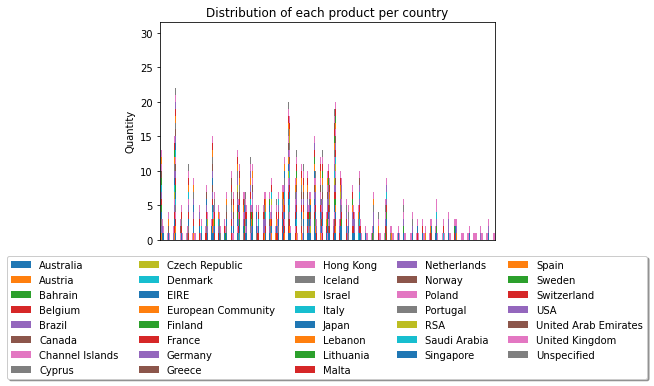

In [8]:
from matplotlib import pyplot as plt

df.createOrReplaceTempView("temp_ProdCount")
sqlProducts = spark.sql("SELECT StockCode, Country, count(Quantity) FROM temp_ProdCount GROUP by StockCode, Country")
# Create a temporary view from this query
sqlProducts.createOrReplaceTempView("distrib_product_country_temp_view")
# Convert to Pandas
pdProducts = sqlProducts.toPandas()
# Create plot settings
ax = plt.gca()
plt.title('Distribution of each product per country')
ax.axes.xaxis.set_visible(False)
plt.ylabel('Quantity')
plt.xticks([])
# Plot the distribution of products as bar plot, the bar of product quantity is separated by country
pdProducts.groupby(['StockCode','Country']).size().unstack().plot(kind='bar',stacked=True, ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

## What is the distribution of prices ?
Here we create a view corresponding to the list of UnitPrice. We then convert it to pandas in order to make a graph by plotting this distribution with matplotlib.pyplot
The same process can be applied to Total Prices by simply modifying the sql query (not done here)

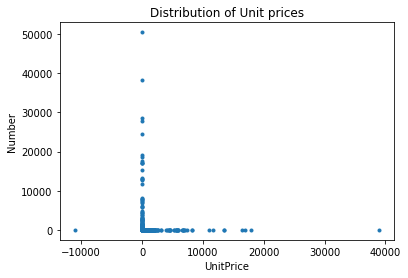

In [9]:
df.createOrReplaceTempView("temp_Prices")
sqlPrices = spark.sql("SELECT UnitPrice, count(UnitPrice) FROM temp_Prices GROUP by UnitPrice")
# Create a temporary view from this query
sqlPrices.createOrReplaceTempView("distrib_prices_temp_view")
# Convert to Pandas
pdPrices = sqlPrices.toPandas()
# Create plot settings
ax = plt.gca()
plt.title('Distribution of Unit prices')
plt.xlabel('UnitPrice')
plt.ylabel('Number')
# Plot the distribution of unit prices
pdPrices.plot(x='UnitPrice',y='count(UnitPrice)', ax=ax, legend=None, marker='.', linestyle='none')
plt.show()

As we can see in this plot there are several extreme values for UnitPrice that occurs only once. The main conclusion we can have is that most of the prices are quite low (we see a kind of line around 0 while some clients paid a big income for a single product.
To better understand the interesting part, below is a second plot zooming on the region of interest corresponding to the distribution of low prices (as additional information).

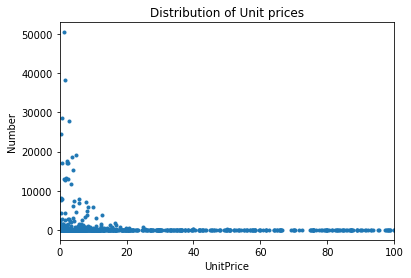

In [10]:
# Create plot settings
ax = plt.gca()
plt.title('Distribution of Unit prices')
plt.xlabel('UnitPrice')
plt.ylabel('Number')
# Plot the distribution of unit prices
pdPrices.plot(x='UnitPrice',y='count(UnitPrice)', ax=ax, legend=None, marker='.', linestyle='none')
# You can modify this xlim to get a better understanding on distribution around most used unit prices
plt.xlim([0, 100])
plt.show()

## Map the amount of transaction per country
Here we create a view corresponding to the list of Country. We then convert it to pandas in order to make a graph by plotting this distribution with matplotlib.pyplot
After that, a world map is generated plotting this distribution per country.

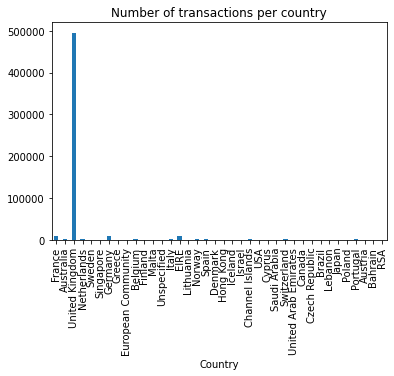

In [11]:
df.createOrReplaceTempView("temp_country")
sqlCountries = spark.sql("SELECT Country, count(Country) FROM temp_country GROUP by Country")
# Create a temporary view from this query
sqlCountries.createOrReplaceTempView("distrib_countries_temp_view")
# Convert to Pandas
pdCountries = sqlCountries.toPandas()
# Create plot settings
ax = plt.gca()
plt.title('Number of transactions per country')
# Plot the number of transactions per country
pdCountries.plot(kind='bar', x='Country',y='count(Country)', ax=ax, legend=None)
plt.show()

Here we can see that the United Kingdom is leading in terms of number of transactions. Actually there are so much transactions for UK that it is difficult to interpret the differences between other countries.
That's why a map world is a better display here for this data compared to previous bar chart.

In [12]:
# Generates latitude and longitude from 3 letters code for countries, to plot on map latter
import numpy as np
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
   
# Modify some countries name to match geopy format
pdCountries.loc[pdCountries['Country']=='RSA', 'Country'] = 'South Africa'
pdCountries.loc[pdCountries['Country']=='USA', 'Country'] = 'United States'
pdCountries.loc[pdCountries['Country']=='EIRE', 'Country'] = 'Ireland'
pdCountries.loc[pdCountries['Country']=='Channel Islands', 'Country'] = 'Guernsey'
pdCountries.loc[pdCountries['Country']=='Czech Republic', 'Country'] = 'Czechia'
# Remove European Community and Unspecified from list as they are not mappable
pdCountries = pdCountries[pdCountries['Country']!='European Community']
pdCountries = pdCountries[pdCountries['Country']!='Unspecified']
                
# declare an empty list to store latitude and longitude of values of country column
longitude = []
latitude = []
   
def findGeocode(country):
    """
    Find the coordinates of a given country Code
    """
    # try and catch is used to overcome the exception thrown by geolocator using geocodertimedout  
    try:
        geolocator = Nominatim(user_agent="MapApp")  
        return geolocator.geocode(country)
      
    except GeocoderTimedOut:
        return findGeocode(country)    
    
# For each country in dataframe, get the corresponding latitude and longitude
for i in (pdCountries["Country"]):
    if findGeocode(i) != None and i != "None":
        loc = findGeocode(i)
        # latitude and longitude returned are stored in 2 different lists
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
    # if coordinate for a city not found, insert "NaN" indicating missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)
    
# Add the new columns to Dataframe
pdCountries['Latitude'] = latitude
pdCountries['Longitude'] = longitude
pdCountries.head()

,Country,count(Country),Latitude,Longitude
0,France,8557,46.603354,1.888334
1,Australia,1259,-24.776109,134.755000
2,United Kingdom,495478,54.702354,-3.276575
3,Netherlands,2371,52.155170,5.387210
4,Sweden,462,59.674971,14.520858


Here the two fields **European Community** and **Unspecified** are dropped as they can't be shown on a map (due to the representation by countries and the difficulty to understand what is the **European Community** when lot of of european countries are already listed.

In [13]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster

# Create an empty map
world_map= folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

#for each coordinate, create circlemarker of number of transactions (to fix an issue of display, the map must be created once without popup and then again with popup)
for i in range(len(pdCountries)):
        lat = pdCountries.iloc[i]['Latitude']
        long = pdCountries.iloc[i]['Longitude']
        # Adapt the radius size according to number of transactions in a lisible way
        if pdCountries.iloc[i]['count(Country)'] > 10000:
            radius = pdCountries.iloc[i]['count(Country)']/15000
        else:
            if pdCountries.iloc[i]['count(Country)'] > 1000:
                radius=pdCountries.iloc[i]['count(Country)']/500
            else:
                radius=pdCountries.iloc[i]['count(Country)']/100
        folium.CircleMarker(location = [lat, long], radius=radius, fill =True).add_to(world_map)
        
#for each coordinate, create circlemarker of number of transactions (recreate the map but with popup message now: To fix display bug)
for i in range(len(pdCountries)):
        lat = pdCountries.iloc[i]['Latitude']
        long = pdCountries.iloc[i]['Longitude']
        # Adapt the radius size according to number of transactions in a lisible way
        if pdCountries.iloc[i]['count(Country)'] > 10000:
            radius = pdCountries.iloc[i]['count(Country)']/15000
        else:
            if pdCountries.iloc[i]['count(Country)'] > 1000:
                radius=pdCountries.iloc[i]['count(Country)']/500
            else:
                radius=pdCountries.iloc[i]['count(Country)']/100
        # Add legend of number of transaction displayed when clicking on the map
        popup_text = """{}<br>
                    transactions in<br>{}<br>"""
        popup_text = popup_text.format(pdCountries.iloc[i]['count(Country)'],
                                   pdCountries.iloc[i]['Country']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(world_map)
# Show the map
print("WORLD MAP DISTRIBUTION OF THE NUMBER OF TRANSACTION BY COUNTRY")
display(world_map)

# Save map
world_map.save('map.html')

WORLD MAP DISTRIBUTION OF THE NUMBER OF TRANSACTION BY COUNTRY


## Create relevant groups of products based on their name and visualize the one with most transactions
Here we will investigate on products name in order to create relevant groups based on their name.
Once these groups are defined, we'll create a new view for it and grouped them to see the one which made the most transactions

In [14]:
# Group all transactions by description of product by counting the number of transactions corrresponding
groups_products = df.groupBy("Description", "StockCode").count()
groups_products.show(groups_products.count(),truncate=False)

+-----------------------------------+------------+-----+
|Description                        |StockCode   |count|
+-----------------------------------+------------+-----+
|POLYESTER FILLER PAD 45x45cm       |46000M      |144  |
|12 PENCILS SMALL TUBE SKULL        |20974       |370  |
|WRAP CHRISTMAS SCREEN PRINT        |22049       |35   |
|MINI JIGSAW DINOSAUR               |22547       |103  |
|GLASS JAR DAISY FRESH COTTON WOOL  |22361       |279  |
|LETTER "H" BLING KEY RING          |90214H      |30   |
|OVERNIGHT BAG VINTAGE ROSE PAISLEY |22278       |186  |
|SET/6 RED SPOTTY PAPER CUPS        |21086       |439  |
|SET OF 72 RETROSPOT PAPER  DOILIES |21210       |462  |
|RIBBON REEL CHRISTMAS SOCK BAUBLE  |22739       |327  |
|MIDNIGHT BLUE PAIR HEART HAIR SLIDE|90003C      |25   |
|PORCELAIN BUTTERFLY OIL BURNER     |18098C      |53   |
|BOX OF 24 COCKTAIL PARASOLS        |84692       |603  |
|BOOZE & WOMEN GREETING CARD        |21520       |59   |
|CONDIMENT TRAY 4 BOWLS AND 4 S

In order, to create relevant groups of products based on their name, the best solution would be to apply some NLP solution using scikit-lean library but the limitation is the need of a training dataset.
For this best solution, we'll need some training test to train our ML algorithm and then apply it to this new test dataset in order to make good predictions.
As here we don't have any training dataset (best option would be to have another Excel file containing product names organized by categories), such solution can not be implemented.
We still can prepare this training dataset, by splitting this dataframe in 2 parts (training and testing) and manually categorizing the training part.
As this task can be quite fastidious and due to the short term of this project, we decided to avoid this option even if that would be the best way to create relevant groups of products based on their descriptions.

For information, here are some links describing the solution explained (which is still really interesting for another project maybe):
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
- https://practicaldatascience.co.uk/machine-learning/how-to-create-a-naive-bayes-product-classification-model

Below, we'll try to find a compromised solution to get relevant groups in an easier way.

After going through the dataframe, we found out that some products have the same description but different StockCode, meaning differents products but with same names.
So here we decided to group them by their description, creating new groups from this field instead of exact StockCode, even if this solution is not perfect as some descriptions are a bit different for same products or the differences are very small (like the example below).

In [15]:
# Different descriptions for same StockCode
groups_products[groups_products['StockCode']=="85123A"].show()

+--------------------+---------+-----+
|         Description|StockCode|count|
+--------------------+---------+-----+
|WHITE HANGING HEA...|   85123A| 2302|
|CREAM HANGING HEA...|   85123A|    9|
|wrongly marked ca...|   85123A|    1|
|                   ?|   85123A|    1|
+--------------------+---------+-----+



In [16]:
windowGroups = Window.orderBy(col("count").desc())

# Add a new column row over the partition window
# Use the PySpark filter to display the first row, ie maximum sum of quantities for order, meaning the product sold the most
# You can remove the filter line to display all products ordered from the most to less sold 
max_group = groups_products.withColumn("row",row_number().over(windowGroups)) \
  .filter(col("row") == 1).drop("row") \
  .collect()[0]

print('The products with the most transaction are {} with a total of {} transactions'.format(max_group["Description"],max_group["count"]))

The products with the most transaction are WHITE HANGING HEART T-LIGHT HOLDER with a total of 2302 transactions
